In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

/home/osvaldo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
SEED = 1234567890
np.random.seed(SEED)

#### Code 8.1

In [3]:
num_weeks = int(1e5)
positions = np.empty(num_weeks, dtype=np.int64)
current = 9

for i in range(num_weeks):
    # record current position
    positions[i] = current

    # flip coin to generate proposal
    proposal = current + np.random.choice([-1, 1])
    # now make sure he loops around the archipelago
    proposal %= 10
    
    #move?
    prob_move = (proposal + 1) / (current + 1)
    current = proposal if np.random.uniform() < prob_move else current

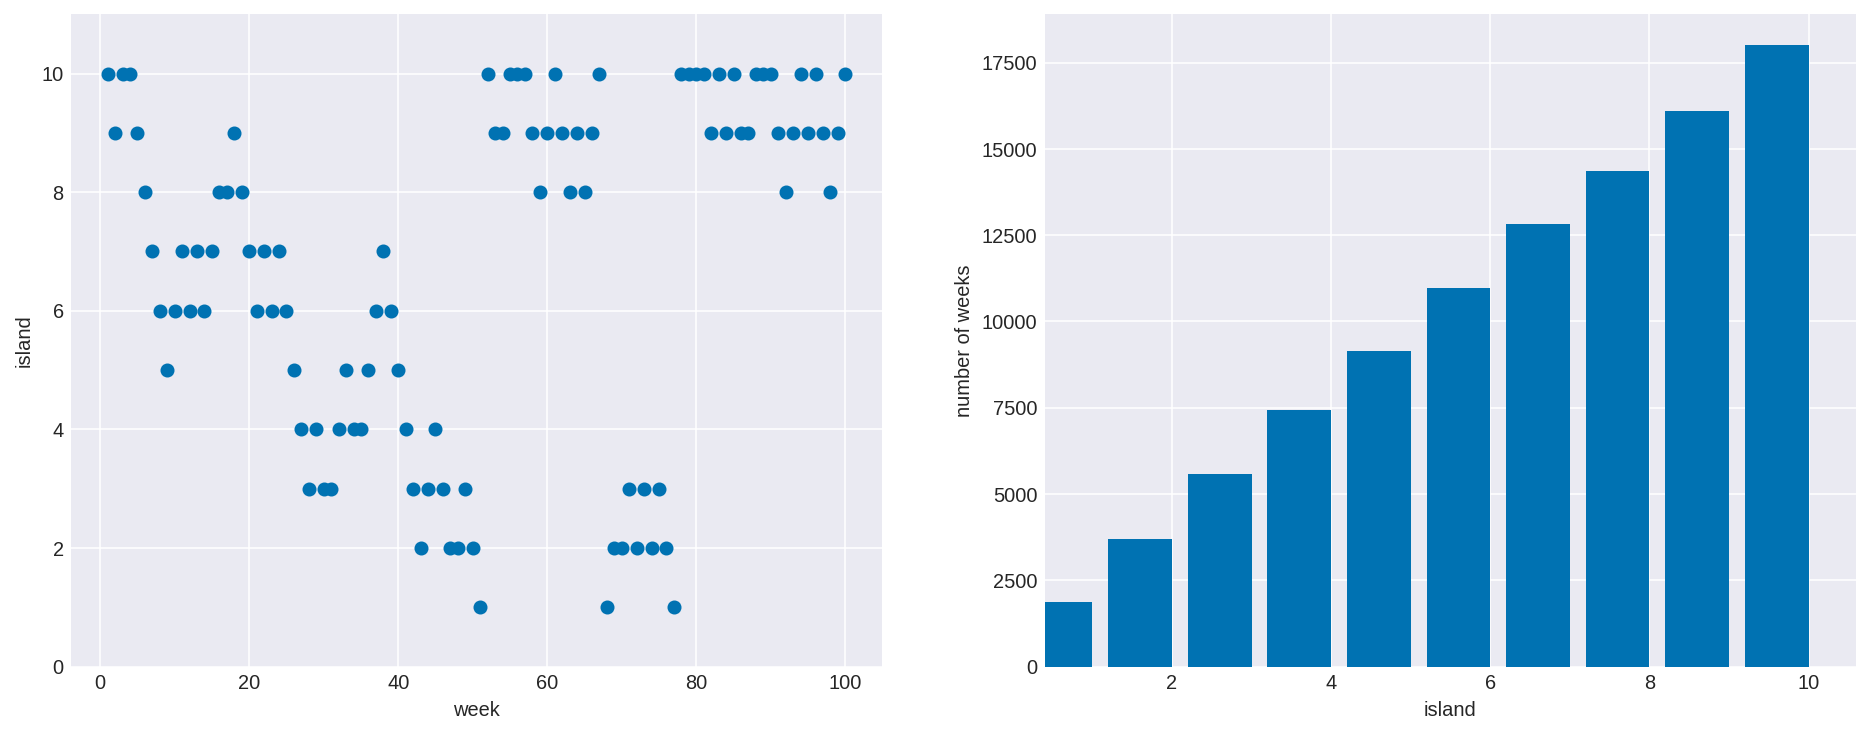

In [4]:
_, (week_ax, island_ax) = plt.subplots(ncols=2, figsize=(16, 6))

week_ax.scatter(np.arange(100) + 1, positions[:100] + 1);

week_ax.set_xlabel('week');
week_ax.set_ylim(0, 11);
week_ax.set_ylabel('island');

island_ax.bar(np.arange(10) + 0.6, np.bincount(positions));

island_ax.set_xlim(0.4, 10.6);
island_ax.set_xlabel('island');
island_ax.set_ylabel('number of weeks');

#### Code 8.2

In [5]:
rugged_df = (pd.read_csv('Data/rugged.csv', sep=';')
               .assign(log_gdp=lambda df: np.log(df.rgdppc_2000))
               .dropna(subset=['log_gdp']))

#### Code 8.3

In [6]:
with pm.Model() as m8_1_map:
    a = pm.Normal('a', 0., 100.)
    bR = pm.Normal('bR', 0., 10.)
    bA = pm.Normal('bA', 0., 10.)
    bAR = pm.Normal('bAR', 0., 10.)
    mu = a \
            + bR * rugged_df.rugged \
            + bA * rugged_df.cont_africa \
            + bAR * rugged_df.rugged * rugged_df.cont_africa
    
    sigma = pm.Uniform('sigma', 0., 10.)
    
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=rugged_df.log_gdp)

In [7]:
with m8_1_map:
    map_8_1 = pm.find_MAP()

logp = -246.89, ||grad|| = 0.297: 100%|██████████| 36/36 [00:00<00:00, 2105.25it/s]           


In [8]:
map_8_1

{'a': array(9.22278924),
 'bR': array(-0.20265346),
 'bA': array(-1.94694634),
 'bAR': array(0.39290435),
 'sigma_interval__': array(-2.27437128),
 'sigma': array(0.9326788)}

#### Code 8.5

In [9]:
with pm.Model() as m8_1:
    a = pm.Normal('a', 0., 100.)
    bR = pm.Normal('bR', 0., 10.)
    bA = pm.Normal('bA', 0., 10.)
    bAR = pm.Normal('bAR', 0., 10.)
    mu = a \
            + bR * rugged_df.rugged \
            + bA * rugged_df.cont_africa \
            + bAR * rugged_df.rugged * rugged_df.cont_africa
    
    sigma = pm.HalfCauchy('sigma', 2.)
    
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=rugged_df.log_gdp)

In [10]:
with  m8_1:
    trace_8_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, bAR, bA, bR, a]
100%|██████████| 2000/2000 [00:04<00:00, 465.12it/s]


In [11]:
pm.summary(trace_8_1, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,9.22,0.14,0.00,9.00,9.43,910.67,1.0
bR,-0.20,0.08,0.00,-0.32,-0.08,959.13,1.0
bA,-1.95,0.22,0.01,-2.27,-1.57,922.27,1.0
bAR,0.39,0.13,0.00,0.19,0.60,1037.85,1.0
sigma,0.95,0.05,0.00,0.86,1.03,1665.26,1.0


#### Code 8.7

In [12]:
with m8_1:
    trace_8_1_4_chains = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, bAR, bA, bR, a]
100%|██████████| 2000/2000 [00:05<00:00, 391.46it/s]


In [13]:
pm.summary(trace_8_1_4_chains, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,9.22,0.14,0.00,8.99,9.44,765.61,1.0
bR,-0.20,0.08,0.00,-0.32,-0.08,798.22,1.0
bA,-1.96,0.23,0.01,-2.33,-1.61,763.16,1.0
bAR,0.40,0.13,0.00,0.20,0.62,844.61,1.0
sigma,0.95,0.05,0.00,0.87,1.03,1613.37,1.0


#### Code 8.8

In [14]:
trace_8_1_df = pm.trace_to_dataframe(trace_8_1)

In [15]:
trace_8_1_df.head()

,a,bR,bA,bAR,sigma
0,9.260830,-0.251784,-2.050571,0.495950,0.945396
1,9.308925,-0.268262,-2.168538,0.545120,0.911904
2,9.281412,-0.183818,-2.017089,0.428908,0.915218
3,9.153152,-0.159671,-2.230641,0.466591,0.951519
4,9.066644,-0.145109,-2.160314,0.456336,0.967085


#### Code 8.9 and 8.10

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


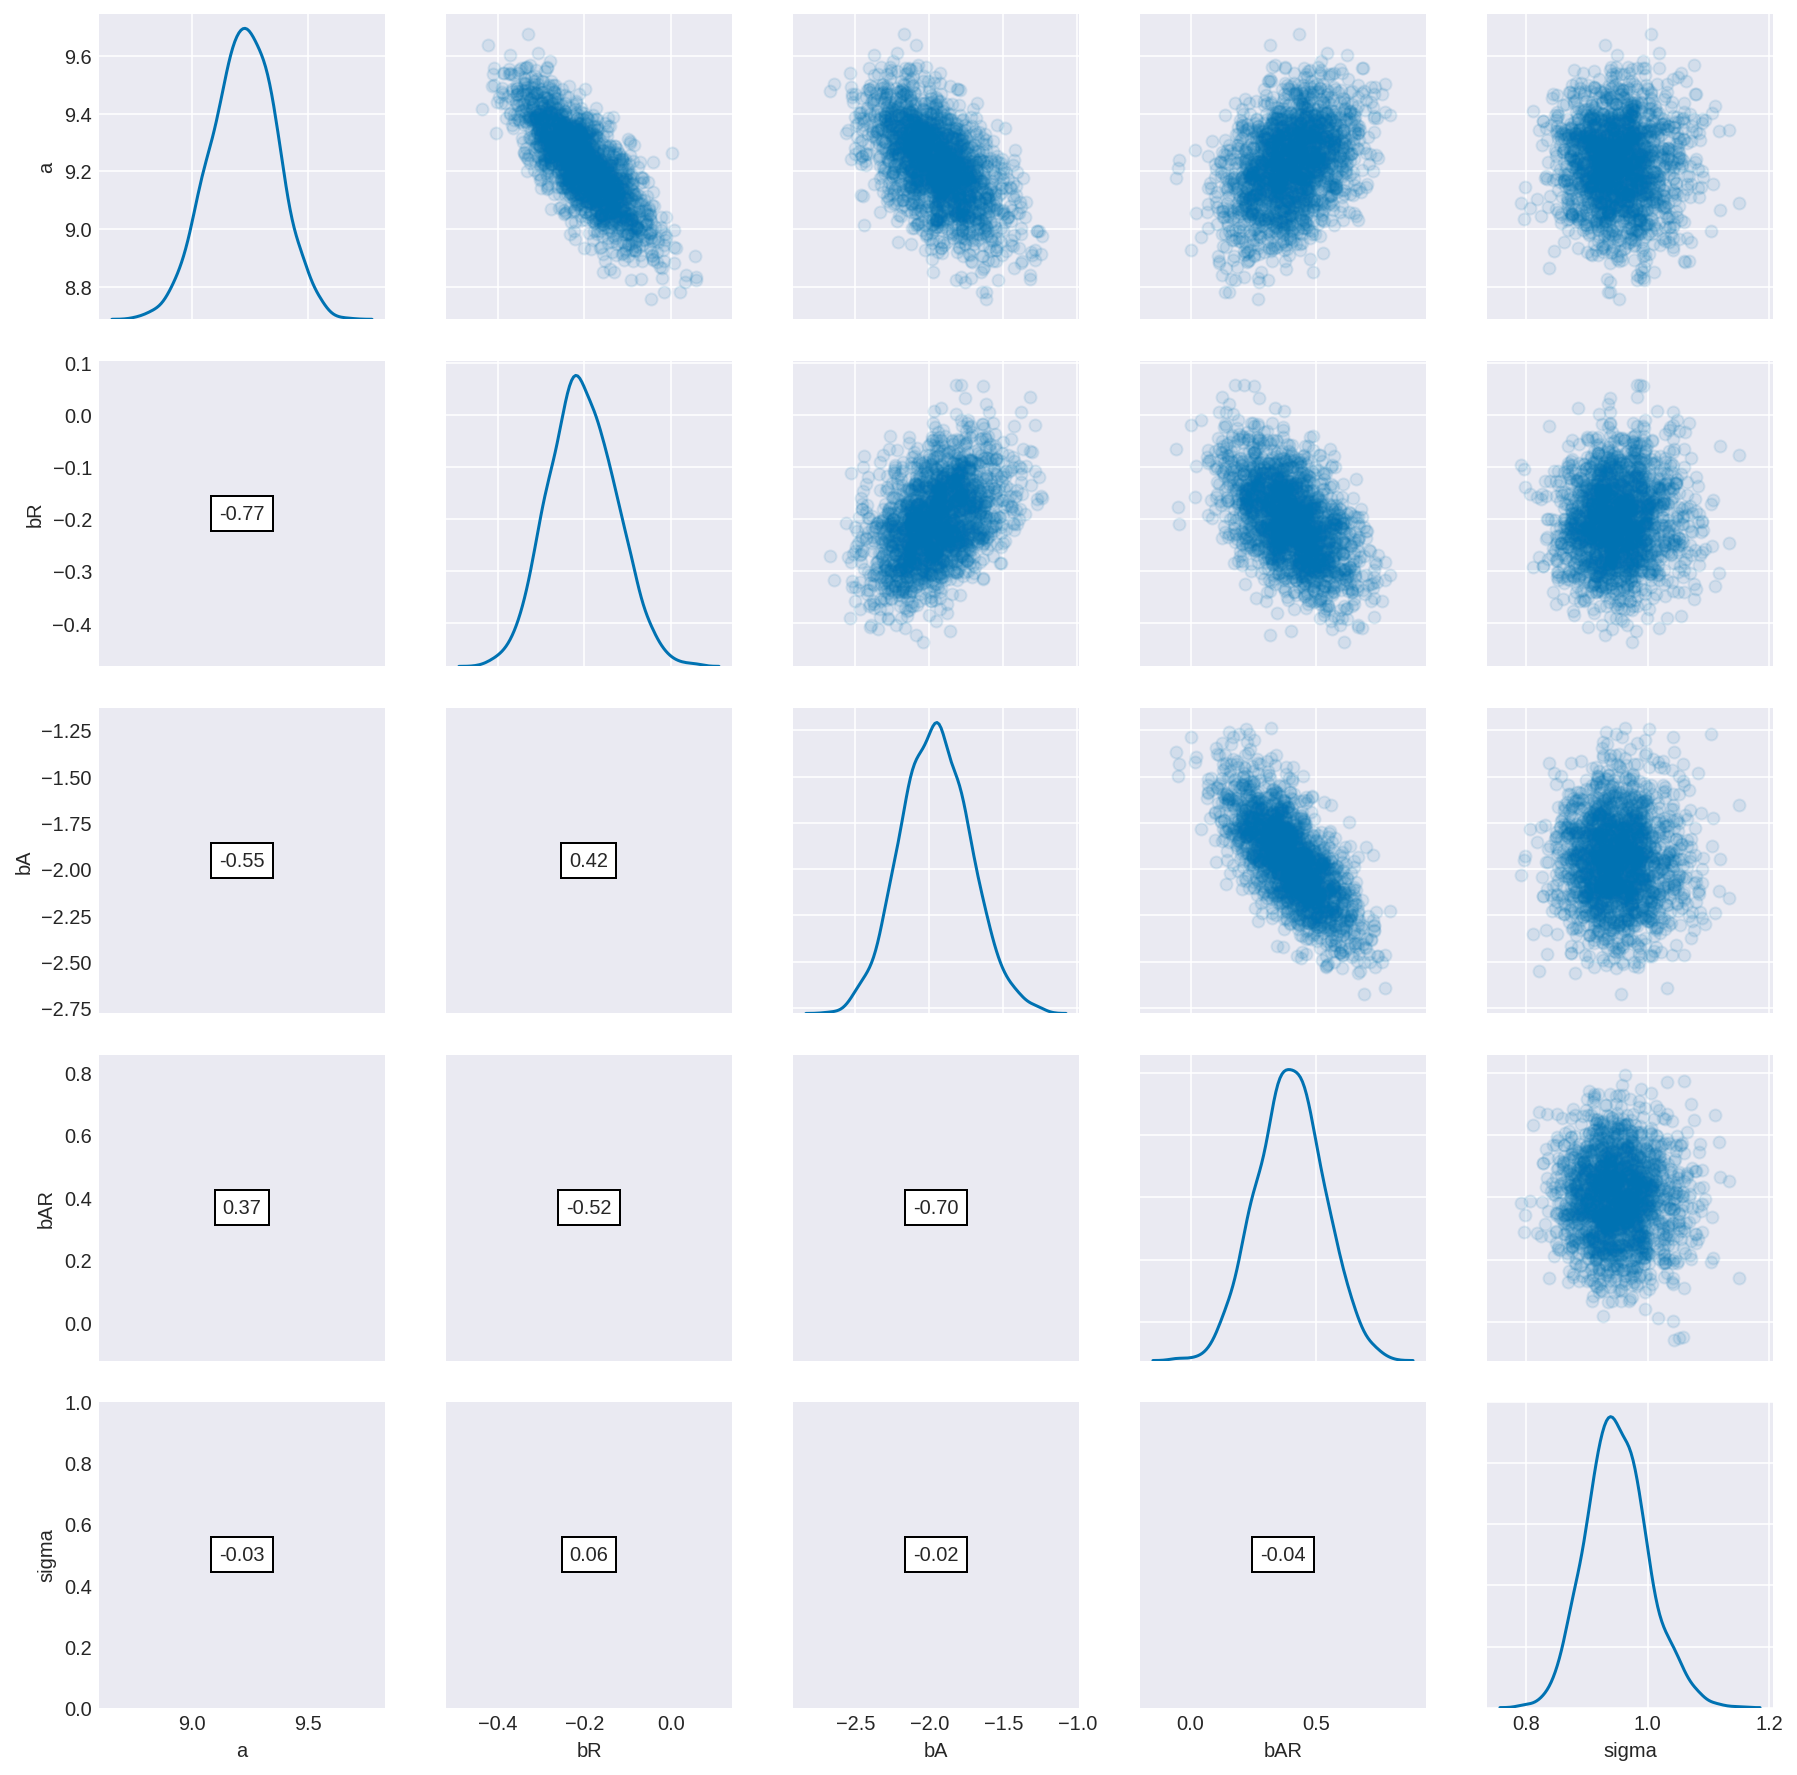

In [16]:
def plot_corr(x, y, **kwargs):
    corrcoeff = np.corrcoef(x, y)[0, 1]
    
    artist = AnchoredText('{:.2f}'.format(corrcoeff), loc=10)
    plt.gca().add_artist(artist)
    plt.grid(b=False)

trace_8_1_df = pm.trace_to_dataframe(trace_8_1_4_chains)
grid = (sns.PairGrid(trace_8_1_df,
                     x_vars=['a', 'bR', 'bA', 'bAR', 'sigma'],
                     y_vars=['a', 'bR', 'bA', 'bAR', 'sigma'],
                     diag_sharey=False)
           .map_diag(sns.kdeplot)
           .map_upper(plt.scatter, alpha=0.1)
           .map_lower(plot_corr))

#### Code 8.11

In [17]:
m8_1.logp({
    varname: trace_8_1[varname].mean()
        for varname in trace_8_1.varnames})

array(-246.04187607)

The computation of DIC has been deprecated and is no longer available in PyMC3

In [18]:
pm.waic(trace_8_1, model=m8_1)

/home/osvaldo/proyectos/00_PyMC3/pymc3/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=469.18334123982186, WAIC_se=14.734518356591463, p_WAIC=5.009398770083736, var_warn=1)

#### Code 8.12

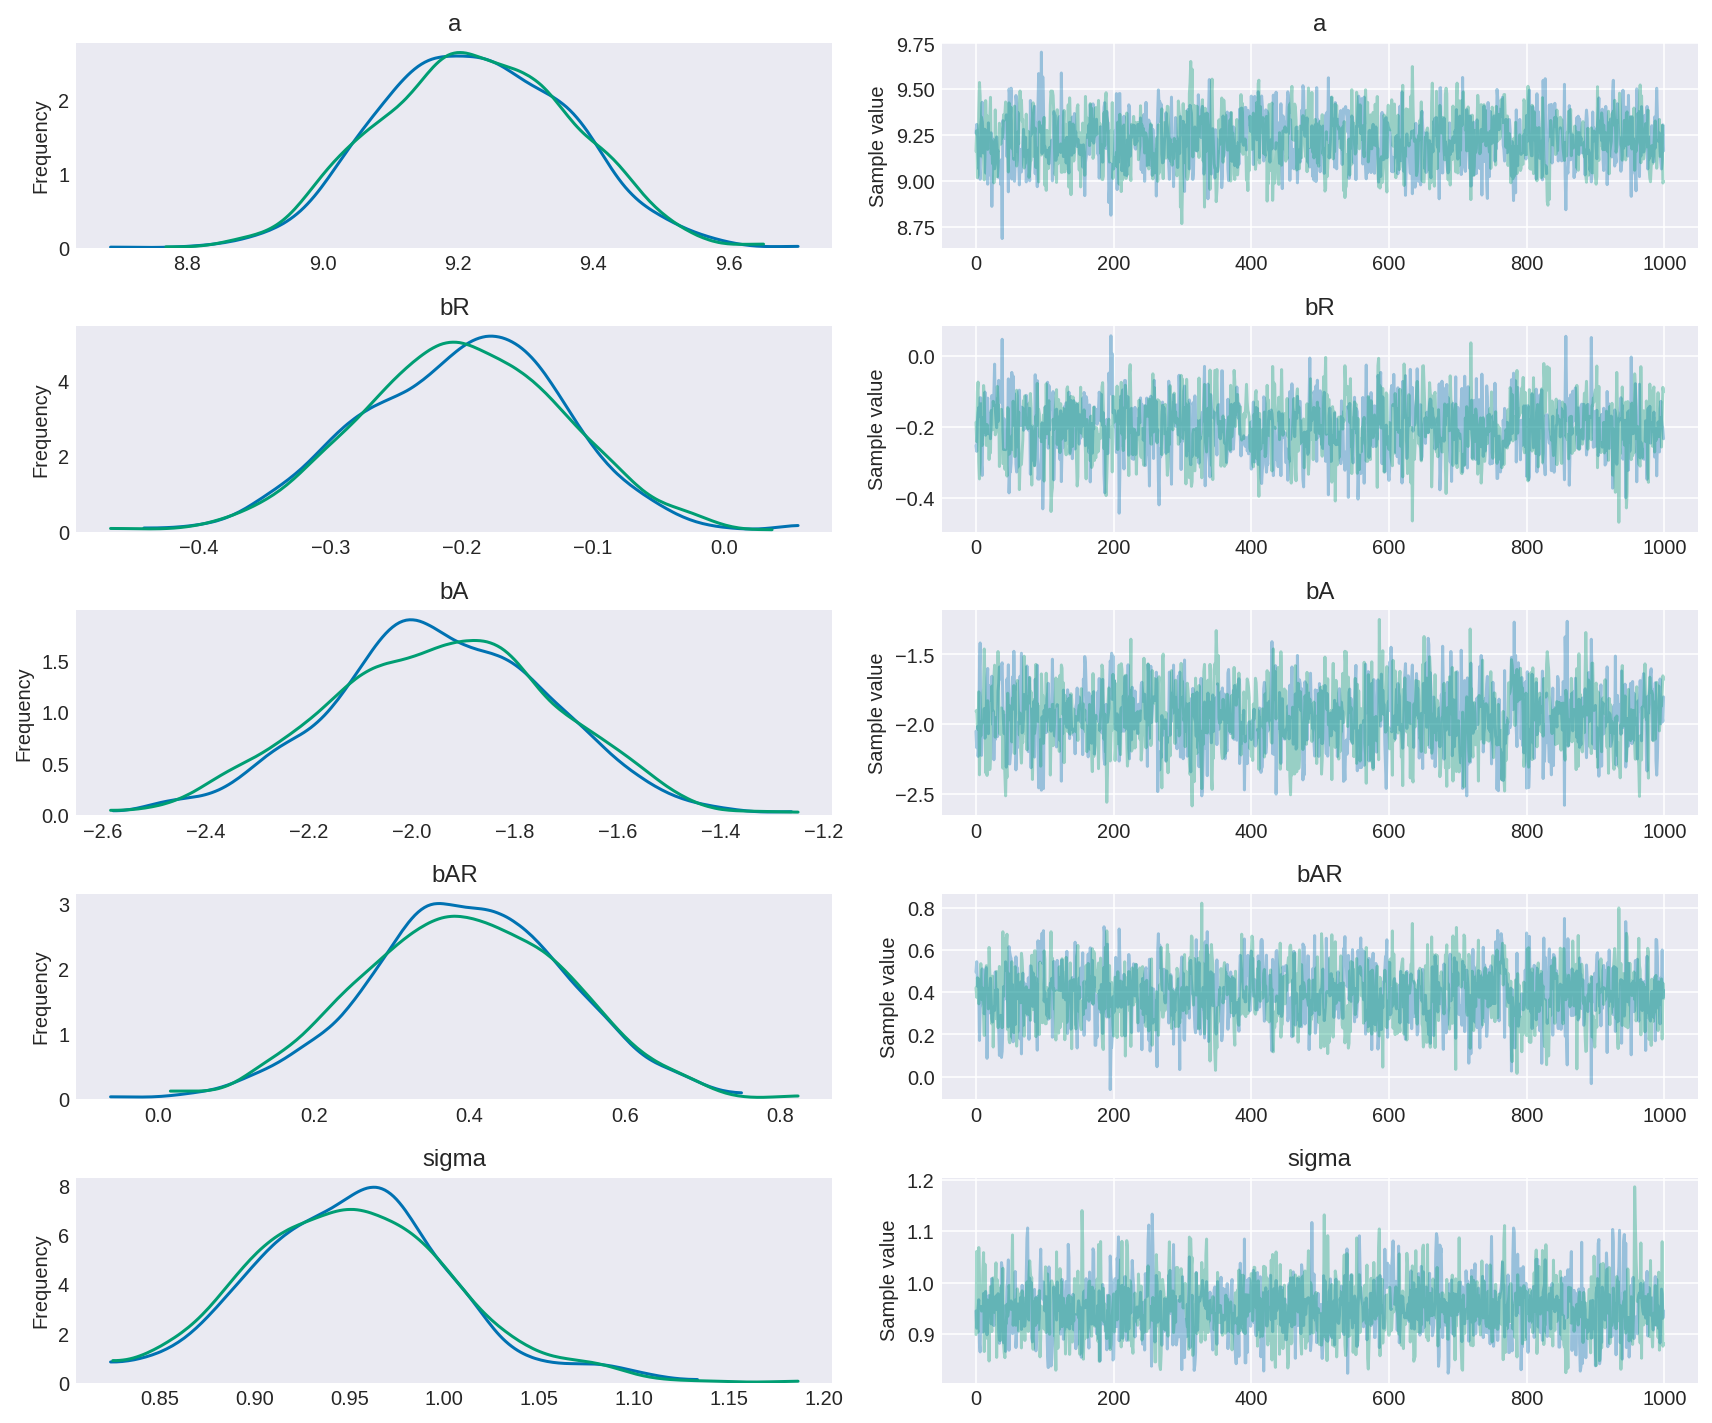

In [19]:
pm.traceplot(trace_8_1);

#### Code 8.13

In [20]:
y = np.array([-1., 1.])

with pm.Model() as m8_2:
    alpha = pm.Flat('alpha')
    sigma = pm.Bound(pm.Flat, lower=0.)('sigma')
    
    y_obs = pm.Normal('y_obs', alpha, sigma, observed=y)

In [21]:
with m8_2:
    trace_8_2 = pm.sample(draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_lowerbound__, alpha]
100%|██████████| 4000/4000 [00:09<00:00, 419.47it/s]
There were 289 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6039401842038931, but should be close to 0.8. Try to increase the number of tuning steps.
There were 357 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7139698915847853, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


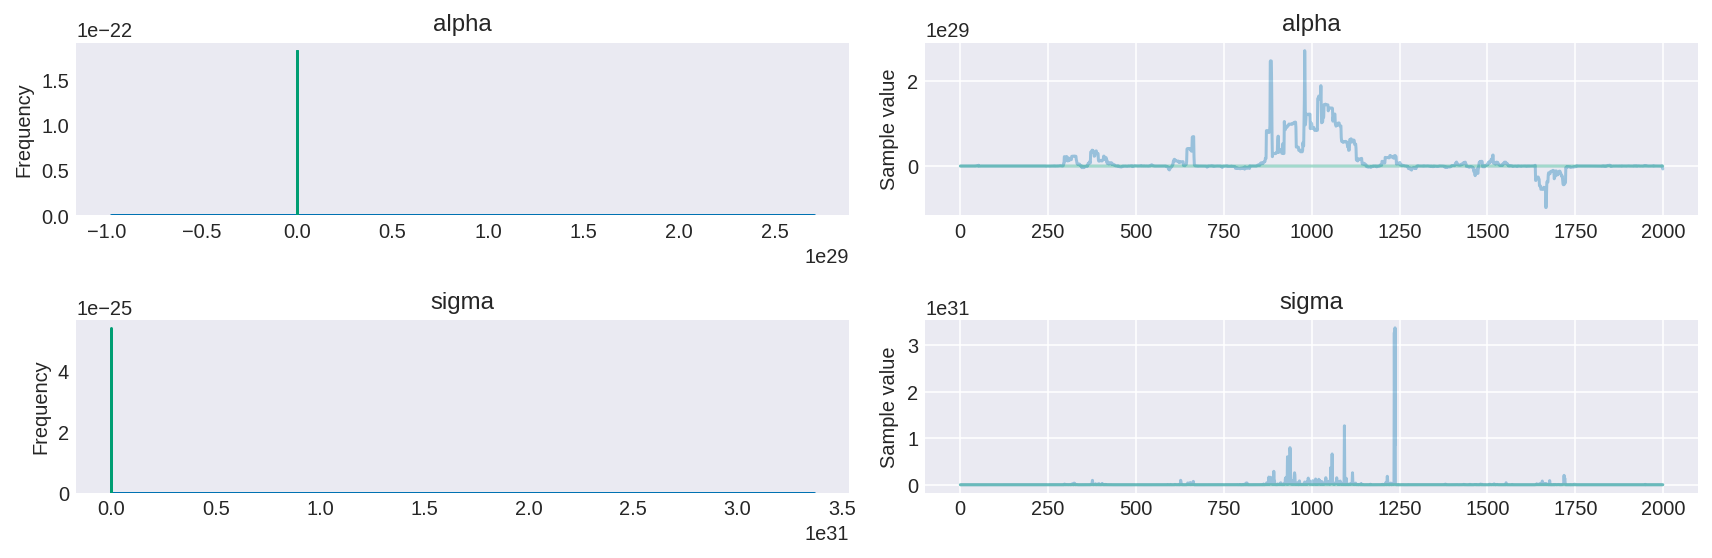

In [22]:
pm.traceplot(trace_8_2);

In [23]:
pm.effective_n(trace_8_2)

{'alpha': 19.09684172223578, 'sigma': 446.7621839093783}

#### Code 8.14

In [24]:
pm.summary(trace_8_2, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
alpha,6.116562e+27,2.550463e+28,2.297147e+27,-6.412876e+27,2.103238e+28,19.10,1.06
sigma,6.389997e+28,8.266868e+29,2.500829e+28,1.806216e+18,4.066042e+28,446.76,1.01


#### Code 8.15

In [25]:
with pm.Model() as m8_3:
    alpha = pm.Normal('alpha', 1., 10.)
    sigma = pm.HalfCauchy('sigma', 1.)
    
    y_obs = pm.Normal('y_obs', alpha, sigma, observed=y)

In [26]:
with m8_3:
    trace_8_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, alpha]
100%|██████████| 2000/2000 [00:01<00:00, 1187.05it/s]
The number of effective samples is smaller than 25% for some parameters.


In [27]:
pm.summary(trace_8_3, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
alpha,0.01,1.39,0.06,-1.99,2.23,470.16,1.0
sigma,1.94,1.76,0.07,0.49,3.39,574.00,1.0


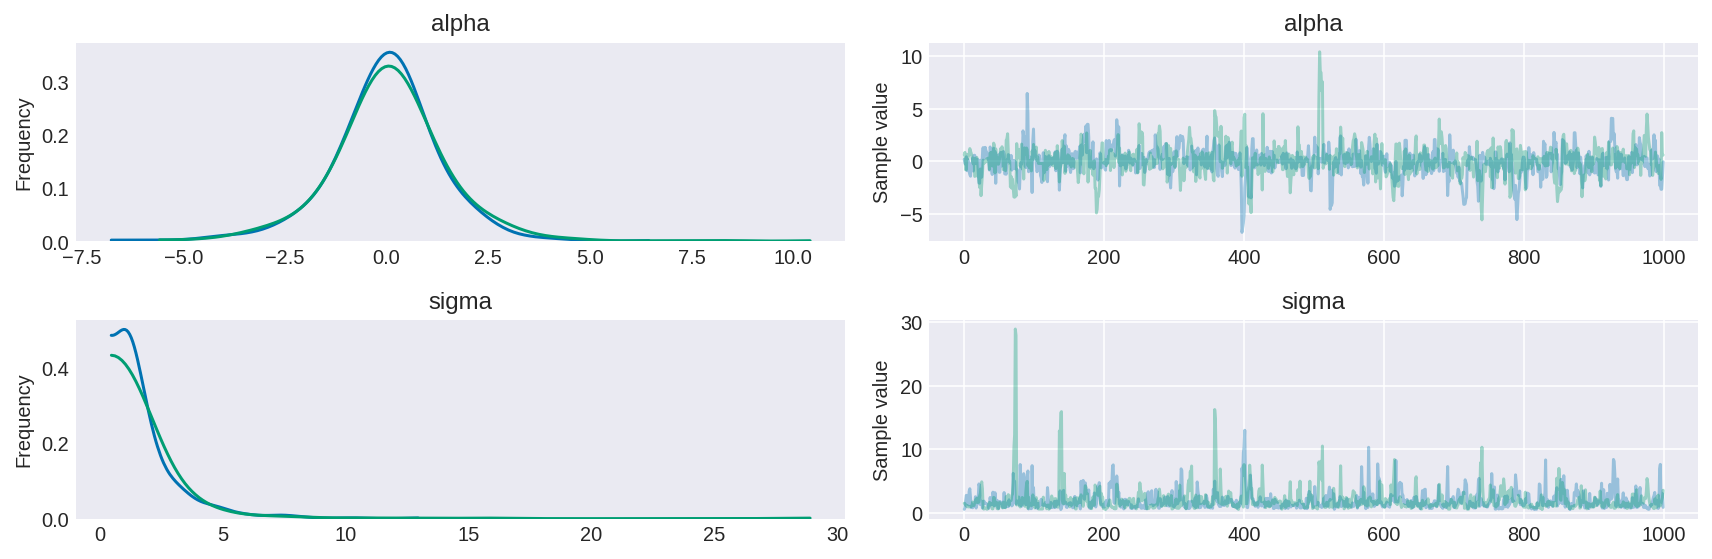

In [28]:
pm.traceplot(trace_8_3);

#### Code 8.16

In [29]:
y = sp.stats.cauchy.rvs(0., 5., size=int(1e4))
mu = y.cumsum() / (1 + np.arange(int(1e4)))

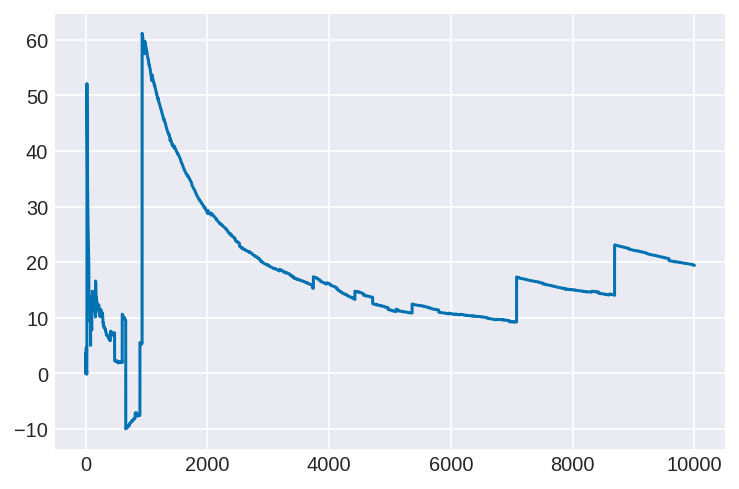

In [30]:
plt.plot(mu);

#### Code 8.17

In [31]:
y = np.random.normal(0., 1., size=100)

#### Code 8.18

In [32]:
with pm.Model() as m8_4:
    a1 = pm.Flat('a1')
    a2 = pm.Flat('a2')
    sigma = pm.HalfCauchy('sigma', 1.)
    
    y_obs = pm.Normal('y_obs', a1 + a2, sigma, observed=y)

In [33]:
with m8_4:
    trace_8_4 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, a2, a1]
100%|██████████| 2000/2000 [01:24<00:00, 23.62it/s]
There were 109 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.18011794165194409, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [34]:
pm.summary(trace_8_4, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a1,-798.73,728.92,72.73,-1725.07,-99.20,1.06,4.68
a2,798.68,728.92,72.73,99.07,1724.99,1.06,4.68
sigma,0.96,0.05,0.00,0.88,1.06,36.08,1.05


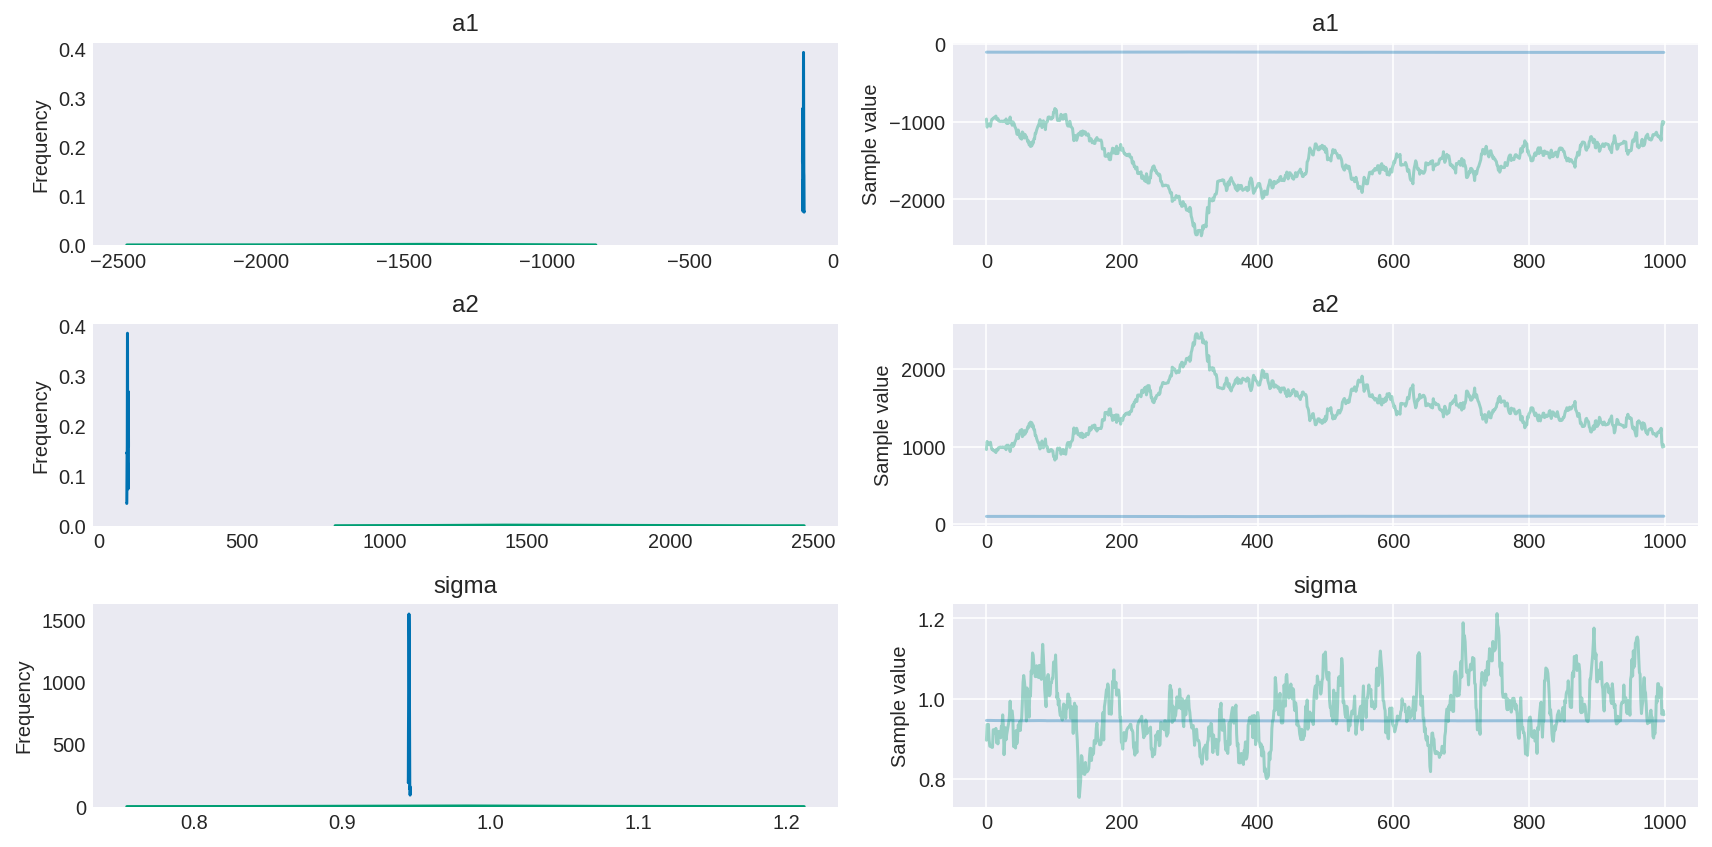

In [35]:
pm.traceplot(trace_8_4);

#### Code 8.19

In [36]:
with pm.Model() as m8_5:
    a1 = pm.Normal('a1', 0., 10.)
    a2 = pm.Normal('a2', 0., 10.)
    sigma = pm.HalfCauchy('sigma', 1.)
    
    y_obs = pm.Normal('y_obs', a1 + a2, sigma, observed=y)

In [37]:
with m8_5:
    trace_8_5 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, a2, a1]
100%|██████████| 2000/2000 [00:56<00:00, 35.38it/s]
The acceptance probability does not match the target. It is 0.8828732409332624, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


In [38]:
pm.summary(trace_8_5, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a1,-0.23,6.83,0.25,-11.26,10.74,623.32,1.0
a2,0.18,6.83,0.25,-10.77,11.22,624.11,1.0
sigma,0.97,0.07,0.00,0.85,1.07,806.98,1.0


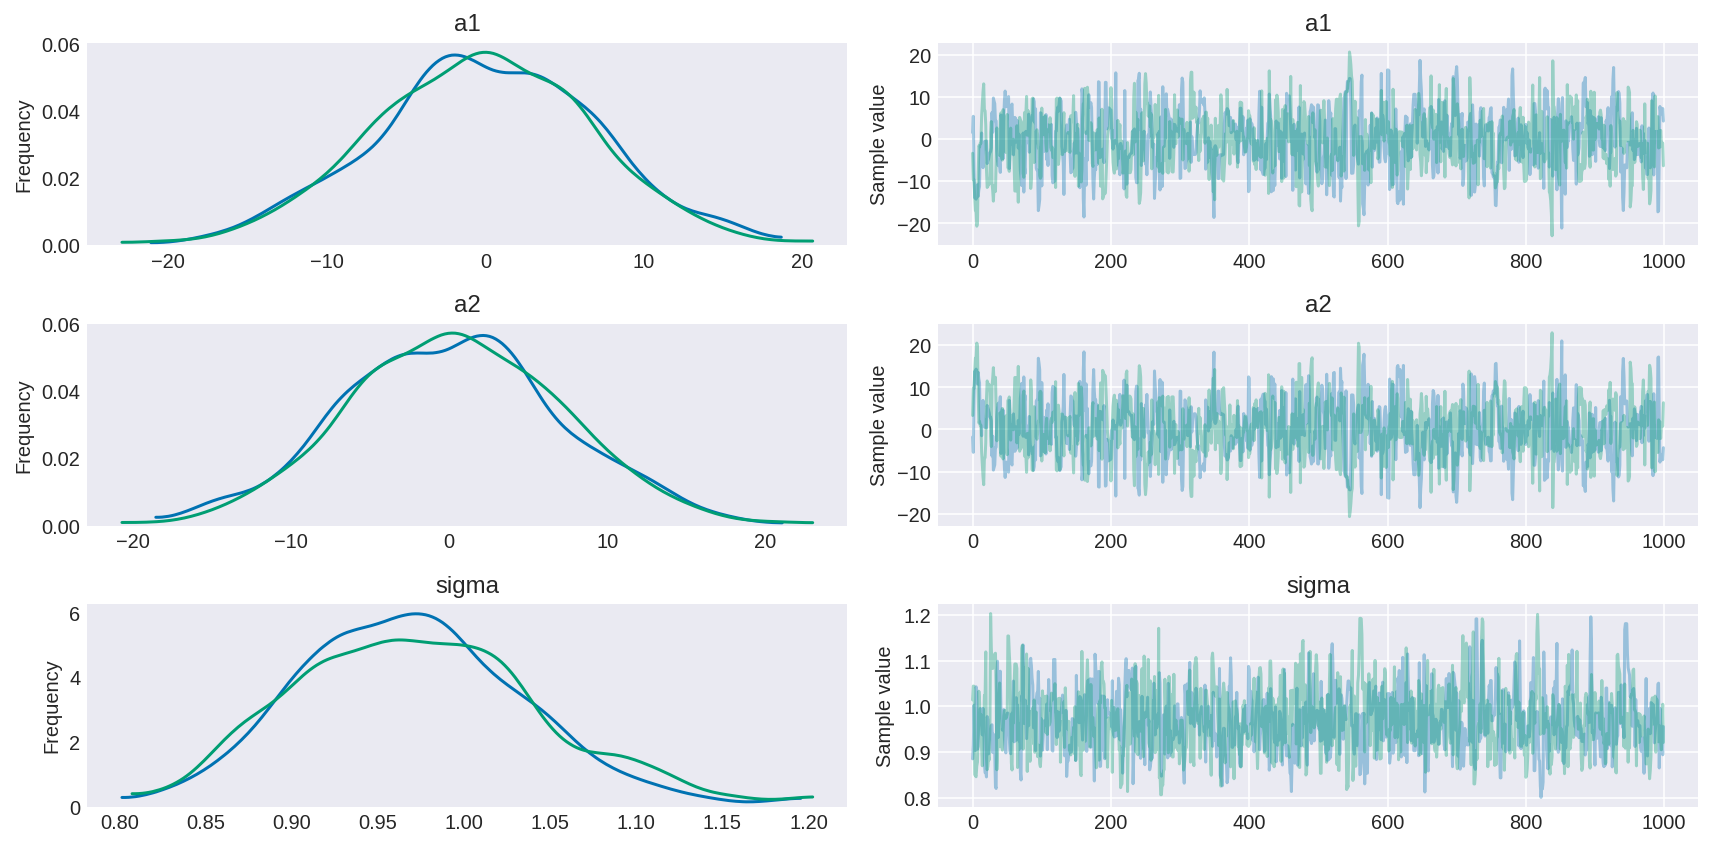

In [39]:
pm.traceplot(trace_8_5);

In [40]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__))

This notebook was createad on a computer x86_64 running debian stretch/sid and using:
Python 3.6.3
IPython 6.3.1
PyMC3 3.4.1
NumPy 1.14.2
Pandas 0.22.0
SciPy 1.0.1
Matplotlib 2.2.2

